In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

import BayesianGit.BayesianOptimiser2.BOPackage as BOPackage

In [2]:
def BraninHoo(X):

    x1 = X[:, 0]
    x2 = X[:, 1]
    
    # Calculate the function value
    y = (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + (5 / np.pi) * x1 - 6) ** 2
    y += 10 * (1 - (1 / (8 * np.pi))) * np.cos(x1) + 10

    # Add the constraint
    constraint = (x1 - 2.5) ** 2 + (x2 - 7.5) ** 2 - 50 >= 0
    y[constraint] = 200  # Apply penalty for constraint violation
        
    # Make function negative to find the minimum
    y = -y.reshape(-1,1)

    return y

In [3]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

# # Example data
# X1 = np.linspace(-5, 10, 100)
# X2 = np.linspace(0, 15, 100)
# X1_grid, X2_grid = np.meshgrid(X1, X2)
# X = np.c_[X1_grid.ravel(), X2_grid.ravel()]
# y = BraninHoo(X)

# # Fit a Gaussian Process with an RBF kernel
# kernel = RBF(length_scale=1.0)  # You can start with an initial guess
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# gp.fit(X, y)

# # Get the optimized length scale
# length_scale = gp.kernel_.length_scale
# print("Estimated Length Scale:", length_scale)

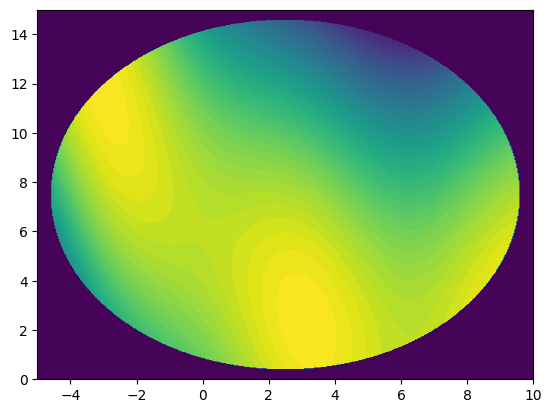

In [4]:
X1 = np.linspace(-5, 10, 501, endpoint=True)
X2 = np.linspace(0, 15, 501, endpoint=True)

# Create the meshgrid
X1_grid, X2_grid = np.meshgrid(X1, X2)

# Combine the grid into an n**2 x 2 matrix
candidate_x = np.c_[X1_grid.ravel(), X2_grid.ravel()]

result = BraninHoo(candidate_x).reshape(X1_grid.shape)

plt.contourf(X1, X2, result, levels=50)

In [5]:
"""
Configure the optimiser.
"""
Kernel = BOPackage.RBF_Kernel
length_scale = 5.0

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 0.5
min_kappa = 0.01

bounds = np.array([[-5, 10], [0, 15]])
dynamic_bounds = True
iterations_between_reducing_bounds = 3
first_reduce_bounds = 10
reduce_bounds_factor = 0.5

n_samples = 10
random_seed = 25

log_path = '/work4/clf/david/Bayesian/BayesianGit/BayesianOptimiser2/Benchmarking/BraninHoo/BraninHoo.log'

if os.path.exists(log_path):   
    subprocess.run(['rm', '-rf', log_path], check=True, text=True, capture_output=True)  

# Create the object
bo = BOPackage.BO(KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  n_samples=n_samples,
                  log_path=log_path,
                  dynamic_bounds=dynamic_bounds,
                  iterations_between_reducing_bounds=iterations_between_reducing_bounds,
                  first_reduce_bounds=first_reduce_bounds,
                  reduce_bounds_factor=reduce_bounds_factor,
                  random_seed=random_seed)

Current best y value was [-0.39822487]; the corresponding X values were [3.13574323 2.26640388]
The bounds have been reduced 6 times


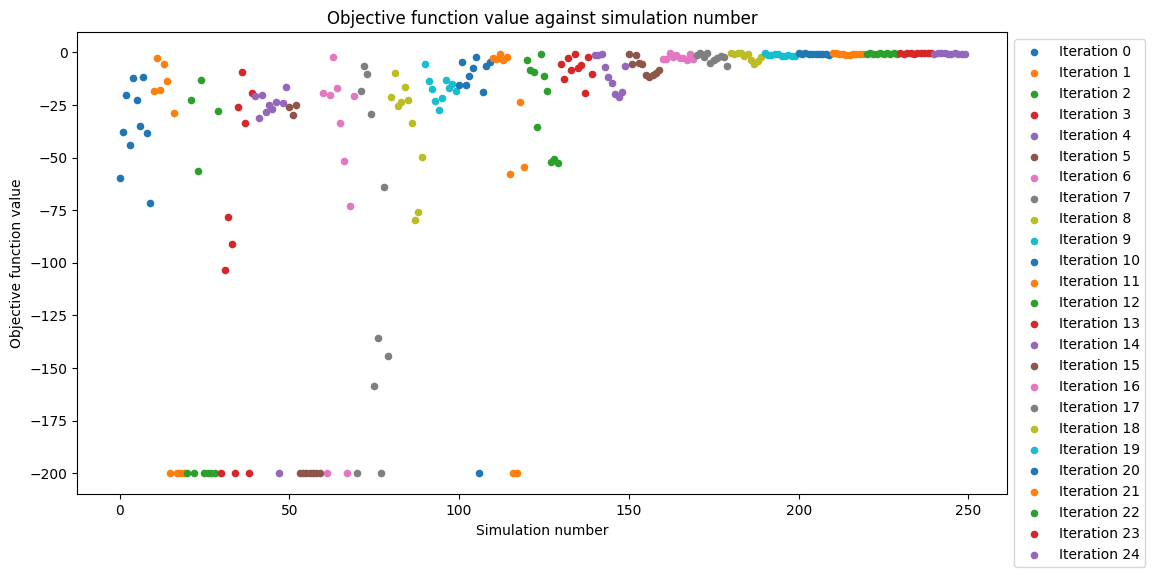

In [6]:
raw_X = bo.GetRandomXBatch(10)
raw_y = BraninHoo(raw_X)
bo.UpdateData(raw_X, raw_y)

for i in range(24):
    raw_X = bo.GetNextXBatch(10, 5, max_kappa=max_kappa, min_kappa=min_kappa)
    raw_y = BraninHoo(raw_X)
    bo.UpdateData(raw_X, raw_y)

bo.PrintCurrentStatus()
BOPackage.PlotData(bo)

In [7]:
print(bo.bounds)

[[3.01855573 3.25293073]
 [2.14921638 2.38359138]]
